# DATA558 Code Release

## Python implementation of a linear SVM

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import warnings

### Training a linear SVM using fast gradient method
We implement a linear support vector machine that uses a squared hinge loss function with an l2 regularisation term. We use the fast gradient method to minimise the loss function with respect to the training data.

In [2]:
def linear_svm(x, y, l, eta_init=1., max_iter=1000, eps=1e-2, include_steps=False):
    """Trains a two-class linear support vector machine using the squared hinge loss
    function. This functions implements a fast gradient descent algorithm to optimise
    the loss function with an l2 regularisation term.
    
    :param x: Training features, as a (d x n) 2d array
    :param y: Training labels, as a (n x 1) 1d array of values +/- 1
    :param l: Regularisation parameter; "lambda" in the equation
    :param eta_init: The initial step size used in backtracking line search
    :param max_iter: The maxmimum number of iterations for gradient descent
    :param eps: The tolerance for the stopping criteron
    :param include_steps: Whether to include the steps of intermediate steps of
    iteratively optimising the decision vectors of the linear SVM.
    
    :returns: either the best trained weights for the input features, or if
    include_steps is True, then also the sequence of trained weights from
    every iteration of the fast gradient method.
    """
    
    if np.any(np.isin(np.unique(y), [-1, 1], invert=True)):
        raise ValueError('labels of y must be either -1 or +1')
    
    d, n = x.shape
    beta = np.zeros(d, dtype=x.dtype)
    theta = np.zeros(d, dtype=x.dtype)
    
    grad = grad_squared_hinge(x, y, beta, l)
    t = 0
    betas = [beta]
    while np.linalg.norm(grad) > eps and t < max_iter:
        eta = backtracking(x, y, theta, l, eta_init)
        new_beta = theta - eta * grad_squared_hinge(x, y, theta, l)
        theta = new_beta + t / (t + 3) * (new_beta - beta)
        beta = new_beta
        betas.append(beta)
        grad = grad_squared_hinge(x, y, beta, l)
        t += 1
    
    if t == max_iter:
        warnings.warn('SVM: Max iterations %d reached. l=%.2e, norm_grad=%.4f' % (max_iter, l, np.linalg.norm(grad)))
    
    return betas if include_steps else betas[-1]

### Backtracking line search
For each iteration in our fast gradient method, we use backtracking line search to find the update step size. This algorithm is implemented below:

In [3]:
def backtracking(x, y, beta, l, eta, alpha=0.5, gamma=0.8, max_iter=100):
    """Perform backtracking line search
    
    :param x: Training features, as a (d x n) 2d array
    :param y: Training labels, as a (n x 1) 1d array of values +/- 1
    :param beta: The current point, as a vector in d-dimensions
    :param l: Regularisation parameter; "lambda" in the equation
    :param eta: The initial step size to use
    :param alpha: A constant used to define when there is a sufficient decrease
    :param gamma: Factor by which to decrease t at each backtracking iteration
    :param max_iter: The maxmimum number of iterations of backtracking
    :returns the step size to use
    """
    obj_beta = squared_hinge(x, y, beta, l)
    grad_beta = grad_squared_hinge(x, y, beta, l)
    norm_grad_beta_squared = grad_beta.T @ grad_beta
    found_eta = False
    i = 0
    while found_eta == False and i < max_iter:
        lhs = squared_hinge(x, y, beta - eta * grad_beta, l)
        rhs = obj_beta - alpha * eta * norm_grad_beta_squared
        if lhs < rhs or np.isclose(lhs, rhs):
            found_eta = True
        else:
            eta *= gamma
            i += 1
        
    if i == max_iter:
        raise Exception('BT: Max iterations reached.')
    
    if np.isclose(eta, 0):
        warnings.warn('BT: Returned step size close to zero')
    
    return eta

### Objective function: squared hinge loss with $\ell_2$ regularisation
Gradient descent requires us to compute the both the objective function and its gradient, which we implement below:

$$
F(\beta) =
\frac{1}{n} \sum_{i=1}^n \left( \max(0, 1 - y_i x_i^T \beta) \right)^2 + \lambda \lVert \beta \rVert_2^2
$$

$$
\nabla F(\beta)
= - \frac{2}{n} \sum_{i=1}^n y_i x_i \max(0, 1 - y_i x_i^T \beta) + 2\lambda\beta
$$

In [4]:
def squared_hinge(x, y, beta, l):
    loss = 1 - y * (x.T @ beta)
    loss = np.mean(np.power(loss * (loss > 0), 2))
    penalty = l * (beta.T @ beta)
    return loss + penalty

In [5]:
def test_squared_hinge(seed=None):
    if seed is None:
        seed = np.random.randint(10000)
    
    print('Test using random seed: %d' % seed)
    np.random.seed(seed)
    n = 100
    d = 20

    # When all beta is zero, the max would always give 1-0=1
    x = np.random.normal(size=(d,n))
    y = np.random.choice([1, -1], n).astype(x.dtype)
    beta = np.zeros(d, dtype=x.dtype)
    l = 0.
    sum_yixi = sum([y[i] * x[:,i] for i in range(n)])
    assert np.isclose(squared_hinge(x, y, beta, l),
                      1 + l * np.linalg.norm(beta)**2)

    # When y_i x_i^T beta >1, max should make it zero
    x = np.random.uniform(1, 1234, size=(d,n))
    y = np.ones(n, dtype=x.dtype)
    beta = np.random.uniform(1, 10, d)
    l = 0.
    assert np.isclose(squared_hinge(x, y, beta, l), 0)

    # When all x is zero, the max would always give 1-0=1
    x = np.zeros((d,n), dtype=np.float64)
    y = np.random.choice([1, -1], n).astype(x.dtype)
    beta = np.random.normal(size=d)
    l = np.random.randint(1234)
    assert np.isclose(squared_hinge(x, y, beta, l),
                      1 + l * np.linalg.norm(beta)**2)
    
    # Sum things the slow way
    x = np.random.normal(size=(d,n))
    y = np.random.choice([1, -1], n).astype(x.dtype)
    beta = np.random.normal(size=d)
    l = np.random.uniform(0, 10)
    summation = sum([max(0, 1 - y[i] * x[:,i].dot(beta))**2 for i in range(n)])
    soln = 1/n * summation + l * np.linalg.norm(beta)**2
    assert np.isclose(squared_hinge(x, y, beta, l),
                      soln)

for i in range(3):
    test_squared_hinge()

Test using random seed: 7409
Test using random seed: 7826
Test using random seed: 4777


### Gradient of the objective function

In [6]:
def grad_squared_hinge(x, y, beta, l):
    yx = y * x
    loss = 1 - yx.T @ beta
    loss = -2 * np.mean(yx * loss * (loss > 0), axis=1)
    penalty = 2 * l * beta
    return loss + penalty

In [7]:
def test_grad_squared_hinge(seed=None):
    if seed is None:
        seed = np.random.randint(10000)
        
    print('Test using random seed: %d' % seed)
    np.random.seed(seed)
    n = 100
    d = 20
    
    # When all x is zero, then we should only be up to the regularisation
    x = np.zeros((d,n), dtype=np.float64)
    y = np.random.choice([1, -1], n).astype(x.dtype)
    beta = np.random.normal(size=d)
    l = np.random.randint(1234)
    np.testing.assert_allclose(grad_squared_hinge(x, y, beta, l), 2 * l * beta)
    
    # When all beta is zero, the max would always give 1-0=1
    x = np.random.normal(size=(d,n))
    y = np.random.choice([1, -1], n).astype(x.dtype)
    beta = np.zeros(d)
    l = 0
    sum_yixi = sum([y[i] * x[:,i] for i in range(n)])
    np.testing.assert_allclose(grad_squared_hinge(x, y, beta, l), -2 / n * sum_yixi)
    
    # When y_i x_i^T beta >1, max should make it zero
    x = np.random.uniform(1, 1234, size=(d,n))
    y = np.ones(n).astype(x.dtype)
    beta = np.random.uniform(1, 10, d)
    l = 0
    np.testing.assert_allclose(grad_squared_hinge(x, y, beta, l), np.zeros(d))
    
    # Sum things the slow way
    x = np.random.normal(size=(d,n))
    y = np.random.choice([1, -1], n).astype(x.dtype)
    beta = np.random.normal(size=d)
    l = np.random.uniform(0, 10)
    summation = sum([y[i] * x[:,i] * max(0, 1 - y[i] * x[:,i].dot(beta)) for i in range(n)])
    soln = -2/n * summation + 2 * l * beta
    np.testing.assert_allclose(grad_squared_hinge(x, y, beta, l), soln)

for i in range(3):
    test_grad_squared_hinge()

Test using random seed: 957
Test using random seed: 362
Test using random seed: 4331


## Testing the algorithm on a simulated dataset

### Generate a simulated dataset
Generate a simulated dataset with 100 observations of each of 5 classes. Each observation has 60 features, each of which has a different random mean but the same within the class. The feature means are different across different classes.

In [8]:
np.random.seed(0)

n = 100 # examples of each class
d = 60 # features
n_classes = 5
classes = np.arange(n_classes) # Class labels

# Generate the mean shifts for each feature of each class
mean_feature_class = np.random.uniform(0, 1, size=(d, n_classes))

# Generate values for each class
X_class = list()
for c in range(n_classes):
    # Generate n examples for each of d features
    x = [np.random.normal(mean_feature_class[j, c], 1, size=n) for j in range(d)]
    
    # Put them together into an (n x d) array
    X_class.append(np.array(x).T)

# Concatenate the generated features for each class
X = np.concatenate(X_class)

# Standardise the data
X = preprocessing.StandardScaler().fit_transform(X)

# Generate the labels
y = np.repeat(classes, n)

## Test the linear SVM on the simulated dataset

In [9]:
def pick_data_ovo(x, y, pair):
    """Returns feature and labels of data points for only the chosen pair of classes.
    
    The response variables are also converted into +/- 1 labels.
    """
    # Pick the data for the two classes
    chosen = np.isin(y, pair)
    x_chosen = x[chosen]
    y_chosen = y[chosen]

    # Convert response variables to +/- 1 labels
    y_chosen = ((y_chosen == pair[1]) * 2 - 1).astype(x.dtype)
    
    return x_chosen, y_chosen

In [10]:
x_chosen, y_chosen = pick_data_ovo(X, y, (0, 1))

betas = linear_svm(x_chosen.T, y_chosen, l=1, include_steps=True)

accuracy = np.mean(np.sign(x_chosen @ betas[-1]) == y_chosen)
print('The trained linear SVM achieved an accuracy of %.2f over the training set' % accuracy)

The trained linear SVM achieved an accuracy of 0.98 over the training set


To illustrate the training process, we can plot the objective function and the norm of the gradient at each iteration.

Text(0.5,1,'Norm of gradient vs iterations')

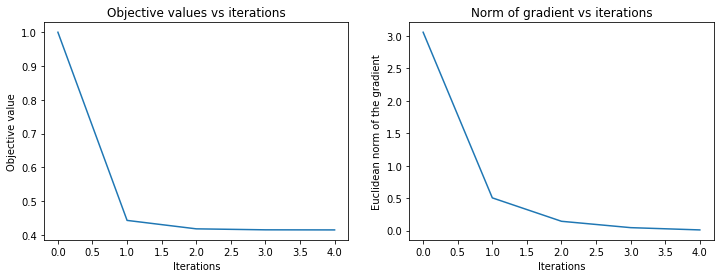

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

objective_values = [squared_hinge(x_chosen.T, y_chosen, beta=b, l=1)
                    for b in betas]
ax1.plot(objective_values)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Objective value')
ax1.set_title('Objective values vs iterations')

norm_grads = [np.linalg.norm(grad_squared_hinge(x_chosen.T, y_chosen, b, l=1))
              for b in betas]
ax2.plot(norm_grads)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean norm of the gradient')
ax2.set_title('Norm of gradient vs iterations')

We see that with each iteration of gradient descent, the objective values becomes smaller and the Euclidean norm of the gradient at the current weight vector gets closer to zero.

## Real world dataset
demo file, that allows a user to launch the method on a real-world dataset of your choice, visualize the training process, and print the performance

In [12]:
# Load the UCI ML hand-written digits datasets from sklearn
from sklearn.datasets import load_digits
digits = load_digits()

Label: 2


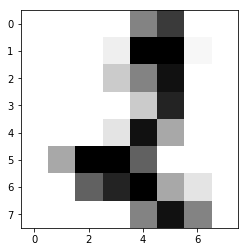

In [13]:
# Visualise the data

%matplotlib inline
import random
import matplotlib.pyplot as plt

i = random.randint(0, 100)

print("Label: %s" % digits.target_names[digits.target[i]])
plt.imshow(digits.images[i], cmap='Greys')

In [14]:
# Understand the data format

print('Shape of "images":', digits.images.shape)
print('Shape of "data":', digits.data.shape)
print('Shape of "target":', digits.target.shape)
print('Shape of "target_names":', digits.target_names.shape)

Shape of "images": (1797, 8, 8)
Shape of "data": (1797, 64)
Shape of "target": (1797,)
Shape of "target_names": (10,)


In [15]:
# Standardise the data

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.25, random_state=0, stratify=digits.target)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

First, test our SVM code on just two of the 10 classes (0 and 1) in the dataset.

In [16]:
x_train_chosen, y_train_chosen = pick_data_ovo(X_train, y_train, (0, 1))
betas = linear_svm(x_train_chosen.T, y_train_chosen, l=1, include_steps=True)

accuracy_train = np.mean(np.sign(x_train_chosen @ betas[-1]) == y_train_chosen)
print('The trained linear SVM achieved an accuracy of %.2f over the training set' % accuracy_train)

x_test_chosen, y_test_chosen = pick_data_ovo(X_test, y_test, (0, 1))
accuracy_test = np.mean(np.sign(x_test_chosen @ betas[-1]) == y_test_chosen)
print('The trained linear SVM achieved an accuracy of %.2f over the test set' % accuracy_test)

The trained linear SVM achieved an accuracy of 1.00 over the training set
The trained linear SVM achieved an accuracy of 1.00 over the test set


### Multiclass classifier using a one-vs-rest strategy
Now that we've confirmed that the linear SVM works to differentiate between two classes, we can construct a multiclass classifier by training one linear SVM for each class. Then, to make a prediction we can simply take the class of the linear SVM corresponding to the largest output value.

We will also use cross validation to select a good value for the regularisation parameter $\lambda$.

In [17]:
def multiclass_ovr_cv(x, y, svm, k, lambdas, **kwargs):
    """Trains a collection of SVMs as a one-vs-rest multiclass classifier.
    Use k-fold cross validation to tune the regularisation parameter lambda.
    :param x: features matrix (n x d)
    :param y: labels vector (n x 1)
    :param svm: linear SVM function
    :param k: number of folds to use for cross-validation
    :param lambdas: an iterable of lambdas to try with cross validation
    """
    
    # Find the best lambda using cross-validation
    scores = [_cv_mean_score(x, y, svm, k, l=l, **kwargs) for l in lambdas]
    
    # Favour larger values of regularisation while maximising score
    best_lambda = lambdas[np.argmax(scores)]
    
    # Train the SVM using the best lambda found
    betas, labels = train_classifier_ovr(x.T, y, svm, l=best_lambda, **kwargs)
    
    return betas, labels, best_lambda

In [18]:
from sklearn.utils import shuffle

def _cv_mean_score(x, y, svm, k, **kwargs):
    """Trains the SVM, and use k-fold cross validation to calculates its
    mean accuracy score across all folds.
    """
    
    if (x.shape[0] != y.shape[0]):
        raise ValueError('lengths %d and %d not aligned' % (x.shape[0], y.shape[0]))
        
    # Shuffle and split the training data into folds
    x, y = shuffle(x, y)
    x_folds = np.array_split(x, k)
    y_folds = np.array_split(y, k)
    
    # Calculate the scores for each fold's cross validation
    scores = [_cv_score_fold(x_folds, y_folds, svm, i, **kwargs)
              for i in range(k)]
    
    return np.mean(scores)

In [19]:
def _cv_score_fold(x_folds, y_folds, svm, i, **kwargs):
    """Trains and scores an SVM for the i-th fold."""
    
    if (len(x_folds) != len(y_folds)):
        raise Exception('x_folds and y_folds should have the same count')
    
    # Extract the i-th fold of X as test set and concat the rest
    xtrain = list(x_folds)
    xtest = xtrain.pop(i)
    xtrain = np.concatenate(xtrain)

    # Extract the i-th fold of y as test set and concat the rest
    ytrain = list(y_folds)
    ytest = ytrain.pop(i)
    ytrain = np.concatenate(ytrain)

    # Standardise X
    scaler = preprocessing.StandardScaler()
    xtrain = scaler.fit_transform(xtrain)
    xtest = scaler.transform(xtest)
    
    # Train the SVM
    betas, labels = train_classifier_ovr(xtrain.T, ytrain, svm, **kwargs)
    
    # Calculate the score
    predicted = predict_ovr(xtest.T, betas, labels)
    
    return np.mean(predicted == ytest)

In [20]:
def train_classifier_ovr(x, y, svm, **kwargs):
    """Trains one SVM per label in a one-vs-rest strategy.
    :param x: features matrix (d x n)
    :param y: labels vector (n x 1)
    :param svm: linear SVM function
    """
    
    if (x.shape[1] != y.shape[0]):
        raise ValueError('lengths %d and %d not aligned' % (x.shape[1], y.shape[0]))
    
    labels = np.unique(y)
    betas = [_train_classifier_label_ovr(x, y, svm, label, **kwargs)
             for label in labels]
    return betas, labels

In [21]:
def _train_classifier_label_ovr(x, y, svm, label, **kwargs):
    # Convert y to +/- 1 labels
    y = ((y == label) * 2 - 1)
    
    # Train the SVM
    return svm(x, y, **kwargs)

In [22]:
def predict_ovr(x, betas, labels):
    highest_score_index = np.argmax([x.T @ beta for beta in betas], axis=0)
    predicted = np.array([labels[idx] for idx in highest_score_index])
    return predicted

For the generated dataset:

In [23]:
%%time

lambdas = 10.**-np.arange(0, 4)
betas, labels, best_lambda = multiclass_ovr_cv(
    X, y, linear_svm, k=3, lambdas=lambdas)

Wall time: 546 ms


In [24]:
predicted = predict_ovr(X.T, betas, labels)
accuracy = np.mean(predicted == y)
    
print('Using cross validation, we found the the best lambda = %.4f' % best_lambda)
print('The accuracy on the training set is %.2f' % accuracy)

Using cross validation, we found the the best lambda = 1.0000
The accuracy on the training set is 0.87


For the digits dataset:

In [25]:
%%time

lambdas = 10.**-np.arange(0, 4)
betas, labels, best_lambda = multiclass_ovr_cv(
        X_train, y_train, linear_svm, k=3, lambdas=lambdas)

Wall time: 9.55 s


In [26]:
predicted = predict_ovr(X_test.T, betas, labels)
accuracy = np.mean(predicted == y_test)

print('Using cross validation, we found the the best lambda = %.4f' % best_lambda)
print('The accuracy on the test set is %.2f' % accuracy)

Using cross validation, we found the the best lambda = 0.1000
The accuracy on the test set is 0.93


## Comparing with scikit-learn
First, try sklearn on the simulated dataset.

In [27]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

parameters = { 'C': 10.**-np.arange(0, 4) }

In [28]:
classifier = LinearSVC(loss='squared_hinge')
grid = GridSearchCV(classifier, parameters, cv=3)

grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.   , 0.1  , 0.01 , 0.001])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
print('Using cross validation, we found the the best C = %.4f' % grid.best_params_['C'])
accuracy = grid.score(X, y)
print('The accuracy on the training set is %.2f' % accuracy)

Using cross validation, we found the the best C = 0.0010
The accuracy on the training set is 0.87


Now, try using Scikit-Learn on the digits dataset.

In [30]:
classifier = LinearSVC(loss='squared_hinge')
grid = GridSearchCV(classifier, parameters, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.   , 0.1  , 0.01 , 0.001])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
print('Using cross validation, we found the the best C = %.4f' % grid.best_params_['C'])
accuracy = grid.score(X_test, y_test)
print('The accuracy on the test set is %.2f' % accuracy)

Using cross validation, we found the the best C = 0.1000
The accuracy on the test set is 0.97


It turns out that the trained Scikit-Learn model had better accuracy than my implementation.  There are several differences - our $\lambda$ regularisation parameter is not identical to the $C$ regularisation parameter from sklearn, so the objective function being optimised is not the same. `GridSearchCV` uses a stratified split, while my implementation of cross validation uses a fully randomised shuffle and split.